In [1]:
#This performs MH algorithm on a fully-observed birth-death process 0->X->0 with birth parameter A and death parameter B.
import pandas as pd
import numpy as np
from scipy.stats import gamma
from scipy.stats import norm
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

In [2]:
#import saved data
full_x=pd.read_csv("full.csv").values
full_t=pd.read_csv("full_time.csv").values
full_react_type=pd.read_csv("full_type.csv").values

In [3]:
#initializations and resizing of data
A_true=5      #indicate true value of A
B_true=0.2    #indicate true value of B
N=5000       #length of the chain
T=20          #end time for observations
A=np.zeros(N+1)
B=np.zeros(N+1)
A[0]=1        #initialize the Markov Chain A
B[0]=1        #initialize the Markov Chain B

var_A=0.2      #set proposal variance for A
var_B=0.01    #set proposal variance for B

Ashape=10    #set the shape of the Gamma prior for A
Ascale=1      #set the scale of the Gamma prior for A
Bshape=0.1   #set the shape of the Gamma prior for B
Bscale=1      #set the scale of the Gamma prior for B

nt=max(i for i in full_t if i <=T )  
t_idx=np.where(full_t==nt)[0][0]
x=np.ndarray.flatten(full_x[:t_idx+1])
t=np.ndarray.flatten(full_t[0:t_idx+1])
react_type=np.ndarray.flatten(full_react_type[0:t_idx+1])

In [4]:
def loglikelihood(y,react_type,aa,bb,t):
    like=0
    for i in range(1,len(y)):
        if react_type[i]==0:
            like +=np.log(aa)
        else:
            like +=np.log(bb*y[i])
            
    h0_vector=np.ndarray.flatten(aa+bb*y)
    t=np.ndarray.flatten(t)
    t_translated=np.ndarray.flatten(np.append(t[1:t_idx+1],T))
    delta_t=t_translated-t
    like += -(np.sum(np.dot(h0_vector,delta_t)))   
    return like

def accept_rate(var,x,react_type,A,B,prop,t,shape,scale1):
    if var=='birth':
        prop_like=loglikelihood(x,react_type,prop,B,t)+np.log(gamma.pdf(prop,a=shape,scale=scale1))+norm.logcdf(A/var_A)
        current_like=loglikelihood(x,react_type,A,B,t)+np.log(gamma.pdf(A,a=shape,scale=scale1))+norm.logcdf(prop/var_A)
    else:
        prop_like=loglikelihood(x,react_type,A,prop,t)+np.log(gamma.pdf(prop,a=shape,scale=scale1))+norm.logcdf(B/var_B)
        current_like=loglikelihood(x,react_type,A,B,t)+np.log(gamma.pdf(B,a=shape,scale=scale1))+norm.logcdf(prop/var_B)
    rate=np.minimum(1,np.exp(prop_like-current_like))
    return rate

In [5]:
#Perform Gibbs sampling
accept=0
for i in range(N):
    if i % 2 != 0:     #MH for A
        propA=-1
        while propA<0:
            propA=A[i]+np.random.normal(0,var_A,1)
        rate=accept_rate('birth',x,react_type,A[i],B[i],propA,t,Ashape,Ascale)
        if np.random.uniform(0,1,1)<rate:
            accept+=1
            A[i+1]=propA
            B[i+1]=B[i]
        else:
            A[i+1]=A[i]
            B[i+1]=B[i]
    else:              #MH for B
        propB=-1
        while propB<0:
            propB=B[i]+np.random.normal(0,var_B,1)
        rate=accept_rate('death',x,react_type,A[i],B[i],propB,t,Bshape,Bscale)
        if np.random.uniform(0,1,1)<rate:
            accept+=1
            B[i+1]=propB
            A[i+1]=A[i]
        else:
            B[i+1]=B[i]
            A[i+1]=A[i]
    
    if (i+1)%200 == 0:
        print('Iteration %d' %(i+1),'A = %1.3f' %(A[i+1]), 'B = %1.3f' %(B[i+1]) )
        
acceptance_rate=accept/N              

Iteration 200 A = 5.185 B = 0.628
Iteration 400 A = 5.641 B = 0.254
Iteration 600 A = 4.547 B = 0.218
Iteration 800 A = 5.480 B = 0.207
Iteration 1000 A = 4.798 B = 0.192
Iteration 1200 A = 4.571 B = 0.178
Iteration 1400 A = 4.402 B = 0.193
Iteration 1600 A = 4.843 B = 0.195
Iteration 1800 A = 5.452 B = 0.182
Iteration 2000 A = 4.886 B = 0.210
Iteration 2200 A = 4.964 B = 0.162
Iteration 2400 A = 4.751 B = 0.197
Iteration 2600 A = 4.668 B = 0.152
Iteration 2800 A = 4.536 B = 0.160
Iteration 3000 A = 4.766 B = 0.189
Iteration 3200 A = 4.645 B = 0.182
Iteration 3400 A = 5.174 B = 0.174
Iteration 3600 A = 4.364 B = 0.181
Iteration 3800 A = 4.907 B = 0.180
Iteration 4000 A = 4.750 B = 0.202
Iteration 4200 A = 5.171 B = 0.220
Iteration 4400 A = 5.402 B = 0.173
Iteration 4600 A = 5.090 B = 0.180
Iteration 4800 A = 4.416 B = 0.198
Iteration 5000 A = 4.254 B = 0.158


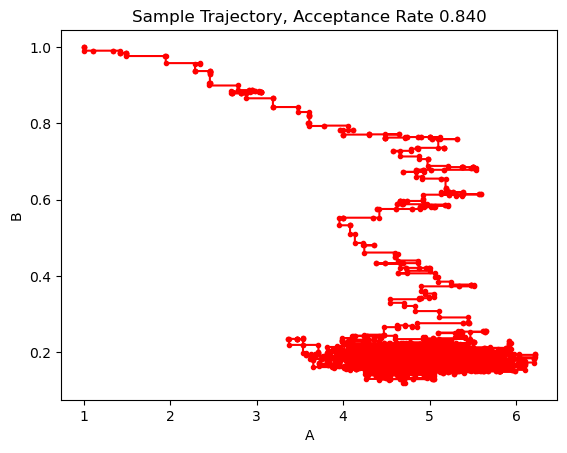

In [6]:
#plot the trajectory
t0=0    #indicate the starting time step 
tf=N     #indicate the terminal time step 
nA=A[t0:tf]
nB=B[t0:tf]
plt.plot(nA, nB, '.r-')
plt.title('Sample Trajectory, Acceptance Rate %1.3f' %acceptance_rate)
plt.xlabel('A')
plt.ylabel('B')
plt.show()

In [7]:
#Burn-in and thinning
burn_in=1000        #indicate burn-in
thin_factor=5       #indicate thinning factor
bA=A[burn_in:]
bB=B[burn_in:]
tA=np.zeros(np.floor((N-burn_in)/thin_factor).astype(int))
tB=np.zeros(np.floor((N-burn_in)/thin_factor).astype(int))
count=0
for i in range(N-burn_in):
    if (i+1)%thin_factor==0:
        tA[count]=bA[i]           #thinned chain A
        tB[count]=bB[i]           #thinned chain B
        count+=1
        
print('The thinned A samples have mean %1.3f and variance %1.3f.' %(np.mean(tA), np.var(tA)))        
print('The thinned B samples have mean %1.3f and variance %1.3f.' %(np.mean(tB), np.var(tB)))

The thinned A samples have mean 4.904 and variance 0.224.
The thinned B samples have mean 0.183 and variance 0.000.


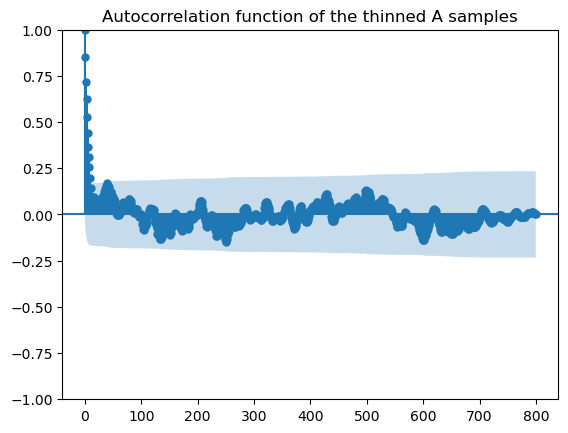

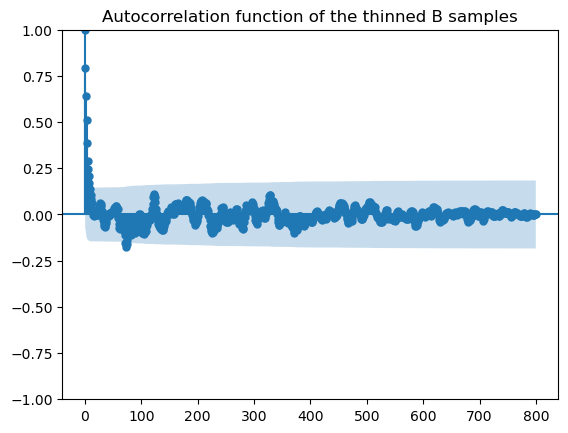

In [8]:
#plot autocorrelation function of the thinned samples
plot_acf(tA,lags=len(tA)-1)
plt.title('Autocorrelation function of the thinned A samples')
plt.show()

plot_acf(tB,lags=len(tB)-1)
plt.title('Autocorrelation function of the thinned B samples')
plt.show()

In [9]:
#detemine the parameters of the true posterior distribution
r=np.zeros(2)
r[0] = len(np.where(react_type==0)[0])
r[1] = len(np.where(react_type==1)[0])

xposA = np.linspace (min(tA), max(tA), 200) 
yposA = gamma.pdf(xposA, a=r[0]+Ashape, scale=1/((1/Ascale)+T))  
xposB = np.linspace (min(tB), max(tB), 200) 
yposB = gamma.pdf(xposB, a=r[1]+Bshape, scale=1/((1/Bscale)+(np.trapz(x,x=t)))) 

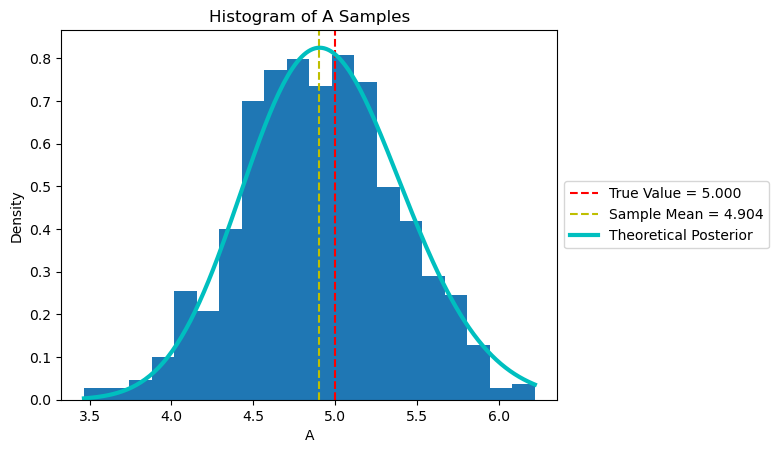

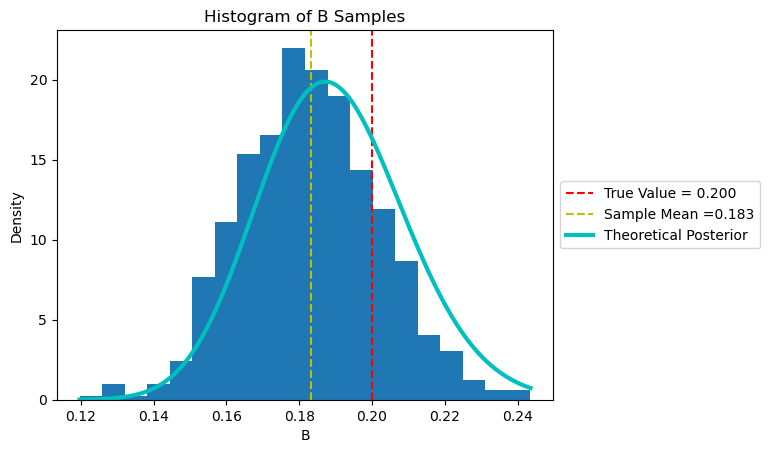

In [10]:
#Histogram of thinned samples
plt.hist(tA, density=True,bins=20)
plt.title('Histogram of A Samples')
plt.axvline(x=A_true,color='r', linestyle='--', label='True Value = %1.3f' %A_true)
plt.axvline(x=np.mean(tA),color='y', linestyle='--', label='Sample Mean = %1.3f' %np.mean(tA))
plt.plot(xposA, yposA, "-c", label='Theoretical Posterior',linewidth=3.0) 
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5))
plt.xlabel('A')
plt.ylabel('Density')
plt.show()

plt.hist(tB, density=True,bins=20)
plt.axvline(x=B_true,color='r', linestyle='--', label='True Value = %1.3f' % B_true)
plt.axvline(x=np.mean(tB),color='y', linestyle='--', label='Sample Mean =%1.3f' % np.mean(tB))
plt.plot(xposB, yposB, "-c", label='Theoretical Posterior',linewidth=3.0) 
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5))
plt.title('Histogram of B Samples')
plt.ylabel('Density')
plt.xlabel('B')
plt.show()